In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [2]:
dataset_dir_vnr = r'D:\Vijayakumar\RandD_2024\NewData'

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),          
    tf.keras.layers.RandomRotation(0.1),               
    tf.keras.layers.RandomZoom(0.1),                   
    tf.keras.layers.RandomBrightness(0.1),             
    tf.keras.layers.RandomContrast(0.1),               
    tf.keras.layers.RandomTranslation(0.05, 0.05),       
])

In [4]:
train_dataset_vnr = tf.keras.utils.image_dataset_from_directory(
    dataset_dir_vnr,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224))

validation_dataset_vnr = tf.keras.utils.image_dataset_from_directory(
    dataset_dir_vnr,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224))


Found 146 files belonging to 6 classes.
Using 117 files for training.
Found 146 files belonging to 6 classes.
Using 29 files for validation.


In [5]:
train_dataset_vnr = train_dataset_vnr.map(lambda x, y: (data_augmentation(x, training=True), y))

train_dataset_vnr = train_dataset_vnr.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_vnr = validation_dataset_vnr.prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
from sklearn.utils.class_weight import compute_class_weight
labels = np.concatenate([y for x, y in train_dataset_vnr], axis=0)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.7222222222222222, 1: 0.8863636363636364, 2: 1.1470588235294117, 3: 1.5, 4: 0.975, 5: 1.0833333333333333}


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Define ResNet50 base model
base_model_vnr = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

input_tensor = base_model_vnr.input

x_vnr = base_model_vnr.output
x_vnr = GlobalAveragePooling2D()(x_vnr)
x_vnr = Dense(256,activation='relu',kernel_regularizer=l2(0.01))(x_vnr)  
x_vnr = BatchNormalization()(x_vnr)
x_vnr = Activation('relu')(x_vnr)
x_vnr = Dropout(0.5)(x_vnr)  
output_tensor = Dense(6, activation='softmax')(x_vnr)

In [8]:
model_vnr = Model(inputs=base_model_vnr.input, outputs=output_tensor)

model_vnr.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [9]:
history_vnr = model_vnr.fit(
    train_dataset_vnr,
    validation_data=validation_dataset_vnr,
    epochs=5,
    class_weight=class_weights_dict
)

Epoch 1/5


4/4 [==============================] - 66s 9s/step - loss: 7.0607 - accuracy: 0.1453 - val_loss: 6.4471 - val_accuracy: 0.2414
Epoch 2/5
4/4 [==============================] - 32s 8s/step - loss: 6.0607 - accuracy: 0.4017 - val_loss: 6.4063 - val_accuracy: 0.3103
Epoch 3/5
4/4 [==============================] - 37s 9s/step - loss: 5.8327 - accuracy: 0.5214 - val_loss: 6.2898 - val_accuracy: 0.3103
Epoch 4/5
4/4 [==============================] - 31s 7s/step - loss: 5.5230 - accuracy: 0.6325 - val_loss: 6.1625 - val_accuracy: 0.3448
Epoch 5/5
4/4 [==============================] - 30s 7s/step - loss: 5.3630 - accuracy: 0.7094 - val_loss: 6.0538 - val_accuracy: 0.3793


In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
img_path_vnr = r'D:\Vijayakumar\RandD_2024\NewData\SCC\scc12.jpg'  
img_vnr = image.load_img(img_path_vnr, target_size=(224, 224))
img_array_vnr = image.img_to_array(img_vnr)
img_array_vnr = np.expand_dims(img_array_vnr, axis=0)  
img_array_vnr = preprocess_input(img_array_vnr) 

In [11]:
import cv2 

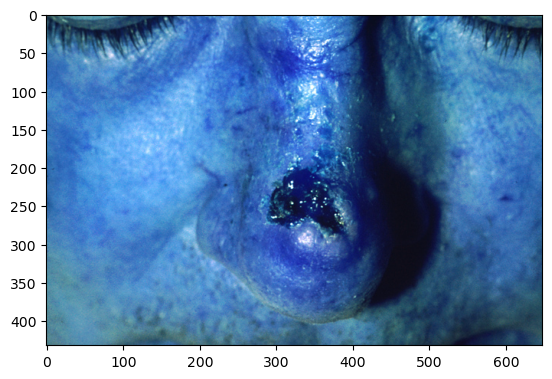

In [12]:
img1 = cv2.imread(r'D:\Vijayakumar\RandD_2024\NewData\SCC\scc12.jpg' )
import matplotlib.pyplot as plt 
plt.imshow(img1)

In [13]:
predictions = model_vnr.predict(img_array_vnr)
predicted_class = np.argmax(predictions, axis=-1)
print(f'Predicted class: {predicted_class[0]}')

1/1 [==============================] - 3s 3s/step
Predicted class: 1


In [14]:
y_pred = model_vnr.predict(validation_dataset_vnr)

1/1 [==============================] - 3s 3s/step


In [15]:
print(type(y_pred))

<class 'numpy.ndarray'>


1/1 [==============================] - 2s 2s/step


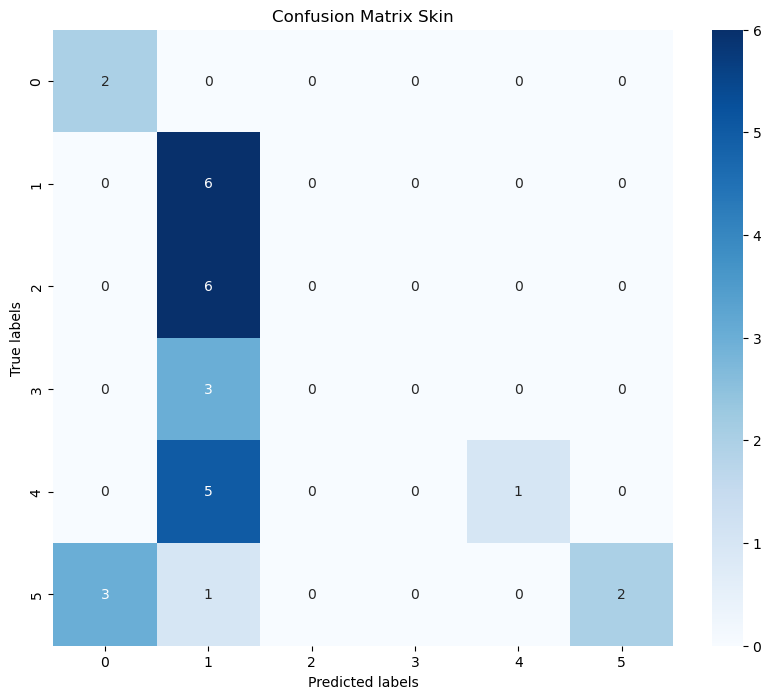

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels_vnr = []
predicted_labels_vnr = []

for images, labels in validation_dataset_vnr:
    predictions_vnr = model_vnr.predict(images)
    predicted_labels_vnr.extend(np.argmax(predictions_vnr, axis=-1))
    true_labels_vnr.extend(labels.numpy())

true_labels_vnr = np.array(true_labels_vnr)
predicted_labels_vnr = np.array(predicted_labels_vnr)

conf_matrix_vnr = confusion_matrix(true_labels_vnr, predicted_labels_vnr)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_vnr, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels_vnr), yticklabels=np.unique(true_labels_vnr))
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix Skin')
plt.show()


In [ ]:
model_vnr.save(model_vnr.h5)